In [1]:
import tensorflow as tf
import numpy as np
import nltk
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from nltk.corpus import gutenberg



In [3]:
# Download NLTK Gutenberg corpus
nltk.download('gutenberg')

# Load and clean texts
texts = {}
book_ids = ['austen-emma.txt', 'austen-persuasion.txt', 'shakespeare-hamlet.txt', 'austen-sense.txt', 'bible-kjv.txt']

for file_id in book_ids:
    texts[file_id] = gutenberg.raw(file_id).lower()


[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [4]:
# Data preparation functions
def prepare_data(text, maxlen=40, step=3):
    sequences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sequences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    chars = sorted(list(set(text)))
    char_indices = {c: i for i, c in enumerate(chars)}
    indices_char = {i: c for i, c in enumerate(chars)}
    return sequences, next_chars, chars, char_indices, indices_char

def vectorize(sequences, next_chars, char_indices, maxlen, num_chars):
    X = np.zeros((len(sequences), maxlen, num_chars), dtype=np.bool_)
    y = np.zeros((len(sequences), num_chars), dtype=np.bool_)
    for i, seq in enumerate(sequences):
        for t, char in enumerate(seq):
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return X, y

def build_model(maxlen, num_chars):
    model = Sequential([
        LSTM(128, input_shape=(maxlen, num_chars)),
        Dense(num_chars, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# Training models
maxlen = 40
step = 3
models = {}
char_indices = {}
indices_char = {}

for key, text in texts.items():
    sequences, next_chars, chars, char_idx, idx_char = prepare_data(text, maxlen, step)
    X, y = vectorize(sequences, next_chars, char_idx, maxlen, len(chars))
    model = build_model(maxlen, len(chars))
    print(f"Training model for: {key}")
    model.fit(X, y, epochs=3, batch_size=128, verbose=2)
    models[key] = (model, char_idx, idx_char, chars)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model for: austen-emma.txt
Epoch 1/3
2310/2310 - 15s - 6ms/step - accuracy: 0.3143 - loss: 2.4103
Epoch 2/3
2310/2310 - 12s - 5ms/step - accuracy: 0.4070 - loss: 2.0156
Epoch 3/3
2310/2310 - 12s - 5ms/step - accuracy: 0.4483 - loss: 1.8620
Training model for: austen-persuasion.txt
Epoch 1/3
1215/1215 - 8s - 7ms/step - accuracy: 0.2736 - loss: 2.5695
Epoch 2/3
1215/1215 - 10s - 8ms/step - accuracy: 0.3632 - loss: 2.1897
Epoch 3/3
1215/1215 - 6s - 5ms/step - accuracy: 0.3970 - loss: 2.0554
Training model for: shakespeare-hamlet.txt
Epoch 1/3
425/425 - 3s - 8ms/step - accuracy: 0.2109 - loss: 2.8385
Epoch 2/3
425/425 - 2s - 6ms/step - accuracy: 0.3027 - loss: 2.4319
Epoch 3/3
425/425 - 2s - 5ms/step - accuracy: 0.3409 - loss: 2.2787
Training model for: austen-sense.txt
Epoch 1/3
1753/1753 - 11s - 6ms/step - accuracy: 0.2998 - loss: 2.4674
Epoch 2/3
1753/1753 - 9s - 5ms/step - accuracy: 0.3918 - loss: 2.0793
Epoch 3/3
1753/1753 - 10s - 5ms/step - accuracy: 0.4326 - loss: 1.9260
Tr

In [6]:
loss, acc = model.evaluate(X, y, verbose=0)
print(f"Character prediction accuracy: {acc:.2f}")

Character prediction accuracy: 0.61


In [8]:
# Generation functions
def generate_next_chars(model, char_idx, idx_char, chars, prompt, length, maxlen):
    generated = [prompt]
    sentence = prompt[-maxlen:]
    for i in range(length):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            if char in char_idx:
                x[0, t, char_idx[char]] = 1
        preds = model.predict(x, verbose=0)[0]
        next_idx = np.argmax(preds)
        next_char = idx_char[next_idx]
        generated += next_char
        sentence = generated[-maxlen:]
    return generated[len(prompt):]

def generate_next_word(text, prompt, length):
    idx = text.find(prompt)
    if idx == -1:
        return f"Prompt not found in text."

    after_prompt = text[idx + len(prompt):]
    words = after_prompt.split()
    next_words = " ".join(words[:length])
    return f"{prompt} {next_words}"



def generate_next_chars_verbatim(text, prompt, length):
    """Extract literal text from original book starting from prompt."""
    idx = text.find(prompt)
    if idx == -1:
        return f"Prompt not found in text."

    return text[idx:idx + len(prompt) + length]



In [9]:
history = model.fit(X, y, epochs=3, batch_size=128, verbose=2)


Epoch 1/3
11283/11283 - 59s - 5ms/step - accuracy: 0.6370 - loss: 1.2074
Epoch 2/3
11283/11283 - 59s - 5ms/step - accuracy: 0.6405 - loss: 1.1930
Epoch 3/3
11283/11283 - 83s - 7ms/step - accuracy: 0.6435 - loss: 1.1814


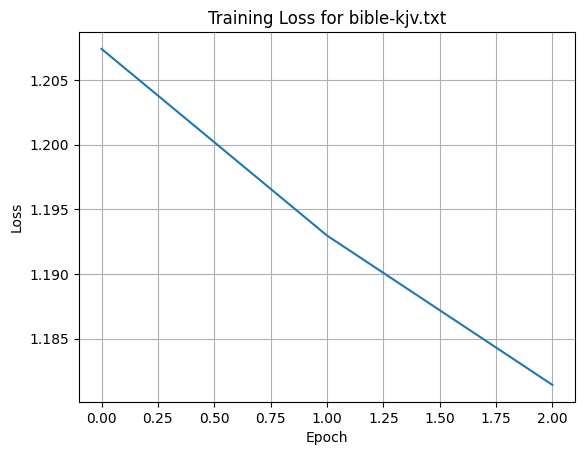

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title(f'Training Loss for {key}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
# User interaction
print("Choose style:")
for i, k in enumerate(models.keys(), 1):
    print(f"{i}. {k}")
choice = int(input("Enter choice number: ")) - 1
style = list(models.keys())[choice]
model, char_idx, idx_char, chars = models[style]

generation_mode = input("Enter 'character' or 'word' for generation: ").strip()
prompt = input("Enter a starting word or sentence: ").lower()
length = int(input("Enter length of output to generate: "))

if generation_mode == 'character':
    output = generate_next_chars_verbatim(texts[style], prompt, length)
    print("Generated text (character-wise literal from book):\n", output)


elif generation_mode == 'word':
    output = generate_next_word(texts[style], prompt, length)
    print("Generated text (word-wise):\n", output)

Choose style:
1. austen-emma.txt
Enter choice number: 1
Enter 'character' or 'word' for generation: character
Enter a starting word or sentence: dearer, tenderer
Enter length of output to generate: 8
Generated text (character-wise literal from book):
 dearer, tenderer recolle
